In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d kumarvishal88/ml-projectdatet
! unzip ml-projectdatet.zip

Saving kaggle.json to kaggle.json
 98% 577M/590M [00:05<00:00, 125MB/s]
100% 590M/590M [00:05<00:00, 121MB/s]
Archive:  ml-projectdatet.zip
  inflating: SignalSourceDataset/Black Bloc - If You Want Success.stem.mp4  
  inflating: SignalSourceDataset/Clara Berry And Wooldog - Stella.stem.mp4  
  inflating: SignalSourceDataset/James May - Dont Let Go.stem.mp4  
  inflating: SignalSourceDataset/Titanium - Haunted Age.stem.mp4  
  inflating: SignalSourceDataset/Wall Of Death - Femme.stem.mp4  
  inflating: VideoCompressionDataset/AlitaBattleAngel.mkv  
  inflating: VideoCompressionDataset/AvengersEndgme.mkv  


In [1]:
import librosa
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.io import wavfile
import pandas as pd
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
warnings.filterwarnings("ignore",category=UserWarning)
warnings.filterwarnings("ignore",category=FutureWarning)
import soundfile as sf
import math
import sys
from numpy.linalg import norm, svd
!pip install pydub
!pip install noisereduce
from pydub import AudioSegment
import noisereduce as nr
from scipy import signal
from moviepy.editor import VideoFileClip
from IPython.display import Audio

In [2]:
def apply_bandpass(y,rate,low,high):
    return signal.sosfiltfilt(signal.butter(10, [low/(0.5*rate), high/(0.5*rate)], btype='bandpass',output='sos'), y)

def robust_pca(S,lamda):
  S_copy=S
  l2_norm=norm(S_copy.ravel(),2)
  linf_norm= norm(S_copy.ravel(),np.inf)/lamda
  dual_norm=np.max([l2_norm,linf_norm])
  S_copy=S_copy/dual_norm
  vocal=np.zeros(S_copy.shape)
  background=np.zeros(S_copy.shape)
  fro_norm=norm(S,'fro')
  mu=1.25/l2_norm
  sv=10
  rho=1.5
  i=0
  print("Loading")
  while True:
    background_raw=S-vocal+(1/mu)*(S_copy)
    background_update=np.maximum(0,background_raw-lamda/mu) + np.minimum(0,background_raw+lamda/mu)
    U,T,V=svd(S-background_update+(1/mu)*S_copy ,full_matrices=False)
    svp=(T>1/mu).shape[0]
    if sv<=svp:
      sv = np.min([svp + round(0.05 *(S_copy.shape[0])),S_copy.shape[0]])
    else:
      sv = np.min([svp + 1,S_copy.shape[0]])

    vocal_update=np.dot(np.dot(U[:, :svp], np.diag(T[:svp] - 1 / mu)), V[:svp, :])
    background=background_update
    vocal=vocal_update
    S_copy=S_copy+(mu*(S-vocal-background))
    mu=np.min([mu*rho,mu*1e8])
    i+=1
    if (i>=1000) or ((norm((S-background-vocal), 'fro')/fro_norm)<1e-8):
      break

  return vocal,background



def model(y,sr,l):
  scaling_factor=2/3
  print(np.sum(np.isnan(y)))
  y=np.nan_to_num(y, nan=1e-7, posinf=1e7, neginf=-1e7)
  S=librosa.core.stft(y,n_fft=1024)
  S=scaling_factor*S
  S_power=np.power(np.abs(S),1)
  vocal_mag,background_mag=robust_pca(S_power,l/math.sqrt(max(S.shape)))
  phase=np.angle(S)
  vocal=vocal_mag*np.exp(1j*phase)
  background=background_mag*np.exp(1j*phase)
  mask=np.abs(background)>np.abs(vocal)
  background_mask=mask*S
  foreground_mask=S-background_mask
  E=librosa.core.istft(background_mask)
  A=librosa.core.istft(foreground_mask)
  E/= np.abs(E).max()
  A/= np.abs(A).max()
  return E, A

def calculate_power(audio_data,sr):
  rmse = librosa.feature.rms(y=audio_data, frame_length=2048, hop_length=512)
  power = np.square(rmse)
  return np.sum(power)

def calculateSNR(audio,noise,sr):
  audio_power=calculate_power(audio,sr)
  noise_power=calculate_power(noise,sr)
  snr= 20*(np.log10(audio_power/noise_power))
  return snr


In [3]:
def pipeline(audio_path):

  # Preprocessings
  audio_name=audio_path.split('/')[-1].split('.')[0]
  final_output=audio_path

  if audio_path.endswith(".mp4"):
    output_wav=audio_name+".wav"
    output_compressed_flac=audio_name+".flac"
    final_output=audio_name+".wav"
    video_clip =VideoFileClip(audio_path)
    audio_clip =video_clip.audio
    audio_clip.write_audiofile(output_wav,codec='pcm_s16le',bitrate='192k',ffmpeg_params=["-ac", "2"])
    audio_compression =AudioSegment.from_wav(output_wav)
    audio_compression.export(output_compressed_flac,format="flac",parameters=["-compression_level","0"])
    AudioSegment.from_file(output_compressed_flac,format="flac").set_frame_rate(44100).set_sample_width(2).set_channels(1).export(final_output,format="wav")

  print("Preprocessing done !")
  y,sr=librosa.load(final_output)
  denoised=nr.reduce_noise(y=y,sr=sr)
  audio=apply_bandpass(denoised,sr,200,2000)
  # apply model
  vocal,back=model(audio,sr,3)
  audio=np.nan_to_num(audio, nan=1e-7, posinf=1e7, neginf=-1e7)
  vocal=np.nan_to_num(vocal, nan=1e-7, posinf=1e7, neginf=-1e7)
  print(f"SNR of Vocals for {audio_name}: ", calculateSNR(vocal,audio,sr))
  sf.write("vocal_"+final_output,vocal,sr)

  y,sr=librosa.load(final_output)
  audio=apply_bandpass(y,sr,50,1200)
  # apply model
  vocal,back=model(audio,sr,1)
  audio=np.nan_to_num(audio, nan=1e-7, posinf=1e7, neginf=-1e7)
  back=np.nan_to_num(back, nan=1e-7, posinf=1e7, neginf=-1e7)
  print(f"SNR of Background for {audio_name}: ", calculateSNR(back,audio,sr))
  sf.write("background_"+final_output,back, sr)






In [5]:
directory="SignalSourceDataset"
audio_path="beliver.wav"
pipeline(audio_path)

Preprocessing done !
0
Loading
SNR of Vocals for beliver:  14.406511783599854
0
Loading
SNR of Background for beliver:  -7.859888076782227


In [ ]:
for audio_path in os.listdir(directory):
  audio_file=os.path.join(directory,audio_path)
  pipeline(audio_path)



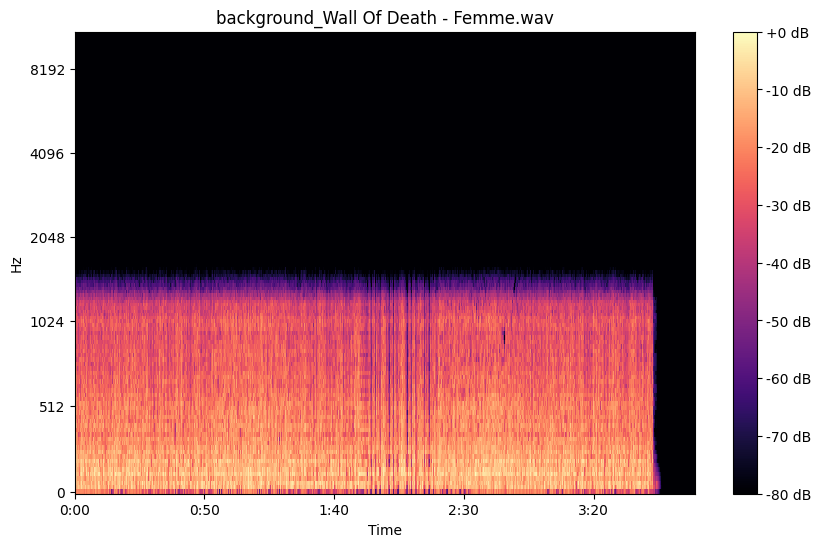

In [ ]:
y, sr = librosa.load("background_Wall Of Death - Femme.wav")
spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
spectrogram_db = librosa.power_to_db(spectrogram, ref=np.max)
plt.figure(figsize=(10, 6))
librosa.display.specshow(spectrogram_db, x_axis='time', y_axis='mel', sr=sr, hop_length=512)
plt.colorbar(format='%+2.0f dB')
plt.title('background_Wall Of Death - Femme.wav')
plt.show()

In [ ]:
Audio("background_roar.wav")